# Introduction

In a telco company, there are two costs known as Acquisition Cost and Retention Cost. Acquisition Cost is the expense for a company to acquire new customers. Meanwhile, Retention Cost is the spending for the company to retain existing customers.

Due to human limitations, we are often wrong to predict which customers will churn and which customers will retain. So that the allocation of funds can be wrong so that the funds issued become larger.

Moreover, according to some sources, the acquisition cost is 7x greater than the retention cost. If we are wrong in predicting a customer who will actually churn, but it turns out that we predict a customer who will retain, then we need to spend more than we should.

## What to do

Through this project, I will try to build a Machine Learning model that can predict which customer is going to churn or is still with us.

#### __1.3 Goal__

The model can predict which customer that are going to leave or stay, so that cost allocation can be determined as precisely as possible.

#### __1.4 Value__

Minimized Acquisition Cost.

#### __1.5 Dataset__

The dataset that I will use is from Kaggle.com. You may visit the dataset through this [link](https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset).

This dataset contains 33 variables (columns) and 7043 observations (rows).

In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.9 MB/s eta 0:00:00


### __2. Preparation__
At this step I will import all the dependencies to work on this project.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import os
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectPercentile, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedStratifiedKFold,\
StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_curve, confusion_matrix, recall_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import category_encoders as ce
from scipy import stats
from scipy.stats import chi2_contingency

#### __2.1 Extract Data From Kaggle__
Extracting the data using Kaggle API.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [6]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [7]:
!kaggle datasets download -d yeanzc/telco-customer-churn-ibm-dataset

 80% 1.00M/1.25M [00:00<00:00, 1.44MB/s]
100% 1.25M/1.25M [00:00<00:00, 1.72MB/s]


In [8]:
!ls

 deep_learning	'Sample - Superstore.csv'	        telco_ibm_clean.csv
 kaggle.json	 telco-customer-churn-ibm-dataset.zip
 logit		 Telco_customer_churn.xlsx


In [9]:
# unzipping the zip files and deleting the zip files
!unzip \*.zip && rm *.zip

Archive:  telco-customer-churn-ibm-dataset.zip
replace Telco_customer_churn.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Telco_customer_churn.xlsx  


In [10]:
telco = pd.read_excel("Telco_customer_churn.xlsx")
telco.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [11]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []

    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())

    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

In [12]:
report(telco)

,Column,d_type,unique_sample,n_uniques
0,CustomerID,object,"[3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOK...",7043
1,Count,int64,[1],1
2,Country,object,[United States],1
3,State,object,[California],1
4,City,object,"[Los Angeles, Beverly Hills, Huntington Park, ...",1129
5,Zip Code,int64,"[90003, 90005, 90006, 90010, 90015]",1652
6,Lat Long,object,"[33.964131, -118.272783, 34.059281, -118.30742...",1652
7,Latitude,float64,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",1652
8,Longitude,float64,"[-118.272783, -118.30742, -118.293953, -118.31...",1651
9,Gender,object,"[Male, Female]",2


From the dataframe above, there are several columns that have one unique value, namely the column [`Count`, `Country`, `State`]. In addition, I will not use the `CustomerID` column because the `customerID` does not determine the probability that someone will churn or not.

`Zip code`, `Lat Long`, `Latitude`, `Longitude` will also be deleted. I won't use it to build Machine Learning model.

I will delete `Churn Score` and `Churn Reason` as well, since in the future getting a customer Churn Score and Churn Reason data before they actualy churn or leave, is impossible. Moreover, it will leak informations when we build the model.

In [13]:
# one time run
new_col = telco.columns.str.replace(' ', '_')
telco.columns = new_col

In [14]:
telco.drop('CustomerID Count Country State Zip_Code Lat_Long Latitude Longitude Churn_Score Churn_Reason'.split(), axis=1, inplace=True)

#### __2.2 Transform The Data__

We can see that there is suspicious column, named "Total Charges". It said that it is an object, but as long as I know, "Total Charge" is a total amount of bill, which is either a float nor integer. I will change the data type into a float.

In [15]:
telco['Total_Charges'].value_counts().to_frame()

,Total_Charges
20.2,11
,11
19.75,9
19.65,8
20.05,8
...,...
444.75,1
5459.2,1
295.95,1
394.1,1


In [16]:
telco['Total_Charges'].replace(' ', np.nan, inplace=True)

In [17]:
telco['Total_Charges'].dtype

dtype('float64')

# __3. Exploratory Data Analysis__

## __3.1 Churn Proportion__

In [18]:
telco['Churn_Label'].value_counts()

No     5174
Yes    1869
Name: Churn_Label, dtype: int64

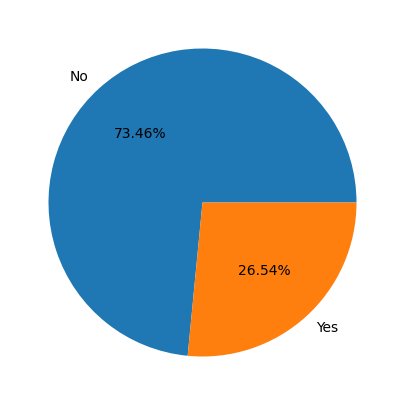

In [19]:
plt.figure(figsize=(10,5))
plt.pie(telco['Churn_Label'].value_counts(), labels=telco['Churn_Label'].value_counts().index, autopct='%.2f%%')
plt.show()

From pie chart above, we can see that 26.54% customers in this dataset labeled as churn customer. Meaning that this dataset is quite imbalanced between the leaving and staying customer. To make a good resulted model, some will straightly think that this dataset needs to be resampled, or in other word, we should "balance" the label. But, up to this point, I still don't want to take that step. I will make another exploration to get more insights.

In [20]:
def cat_vs_churn(column):
  churn_by_ = telco.groupby(column)['Churn_Label'].value_counts(normalize=True).to_frame()
  churn_by_.columns = ['Proportion']
  churn_by_pvt = churn_by_.reset_index().\
  pivot(columns='Churn_Label', index=column, values='Proportion')
  display(churn_by_pvt*100)

  contingency = telco.groupby([column, 'Churn_Label']).agg({'Churn_Label':'count'}).rename(columns={'Churn_Label':'Count'}).reset_index().pivot(index=column, columns='Churn_Label', values='Count')
  stats, p, dof, expected = chi2_contingency(contingency)
  if(p<0.05):
    print(f'Column {column} has strong relationship with Churn label.')
  else:
    print(f'Column {column} has weak relationship with Churn label.')

  churn_by_pvt.plot(kind='bar', stacked=True)
  plt.title(f'Churn proportion by {column}')
  plt.show()

In [21]:
telco.select_dtypes(include='object').columns

Index(['City', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service',
       'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',
       'Payment_Method', 'Churn_Label'],
      dtype='object')

Churn_Label,No,Yes
City,,
Acampo,25.0,75.0
Acton,100.0,NaN
Adelanto,80.0,20.0
Adin,50.0,50.0
Agoura Hills,60.0,40.0
...,...,...
Yreka,100.0,NaN
Yuba City,75.0,25.0
Yucaipa,75.0,25.0


Column City has weak relationship with Churn label.


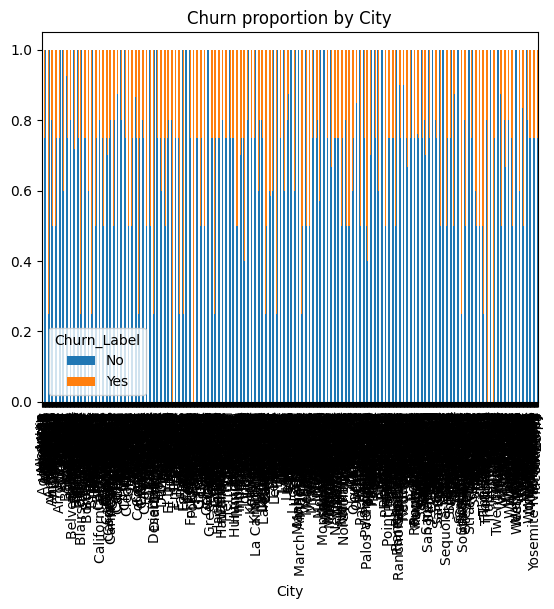

Churn_Label,No,Yes
Gender,,
Female,73.079128,26.920872
Male,73.839662,26.160338


Column Gender has weak relationship with Churn label.


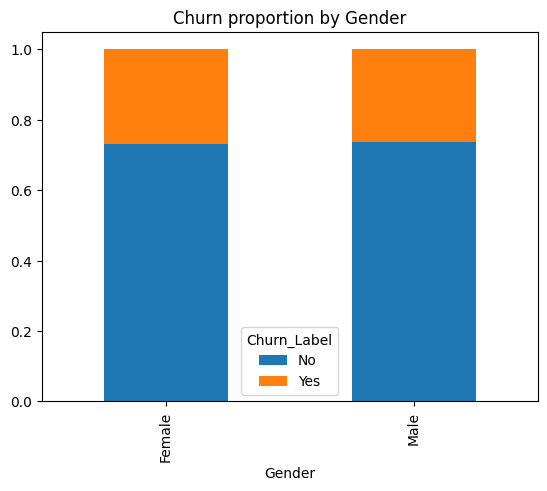

Churn_Label,No,Yes
Senior_Citizen,,
No,76.393832,23.606168
Yes,58.318739,41.681261


Column Senior_Citizen has strong relationship with Churn label.


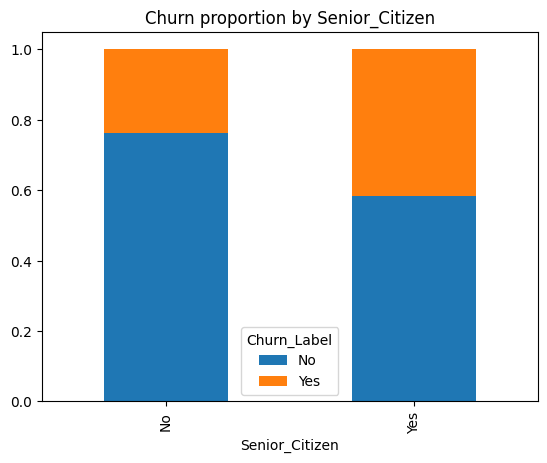

Churn_Label,No,Yes
Partner,,
No,67.042021,32.957979
Yes,80.335097,19.664903


Column Partner has strong relationship with Churn label.


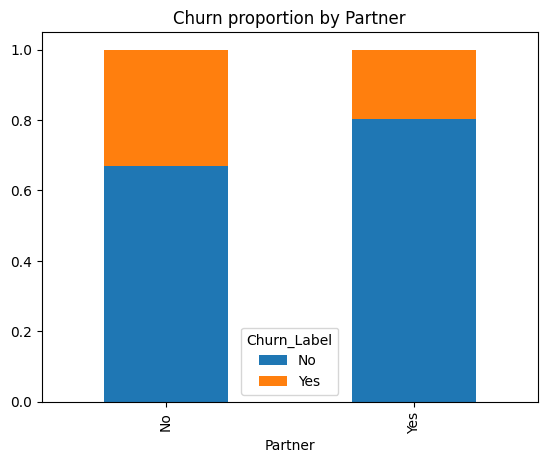

Churn_Label,No,Yes
Dependents,,
No,67.448301,32.551699
Yes,93.484942,6.515058


Column Dependents has strong relationship with Churn label.


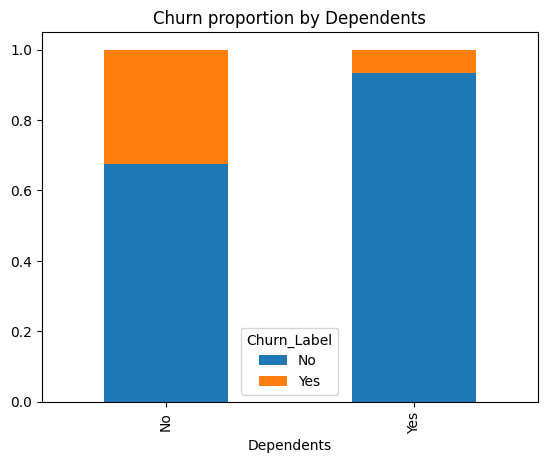

Churn_Label,No,Yes
Phone_Service,,
No,75.073314,24.926686
Yes,73.290363,26.709637


Column Phone_Service has weak relationship with Churn label.


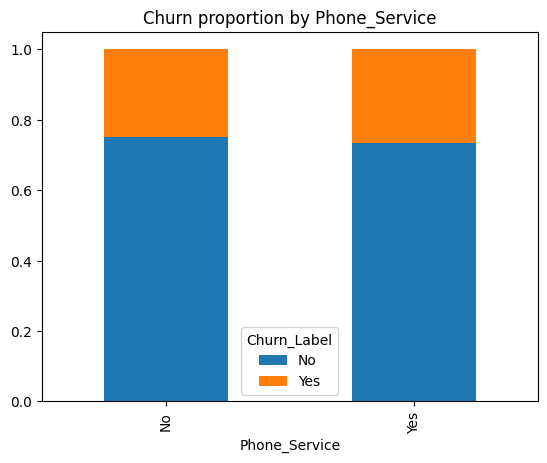

Churn_Label,No,Yes
Multiple_Lines,,
No,74.955752,25.044248
No phone service,75.073314,24.926686
Yes,71.390104,28.609896


Column Multiple_Lines has strong relationship with Churn label.


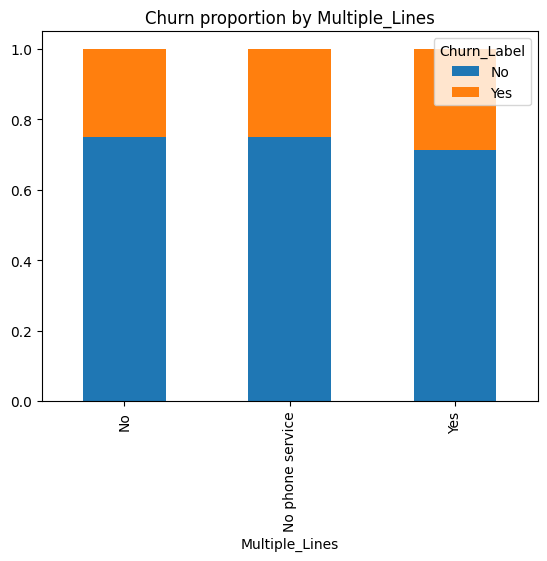

Churn_Label,No,Yes
Internet_Service,,
DSL,81.040892,18.959108
Fiber optic,58.107235,41.892765
No,92.595020,7.404980


Column Internet_Service has strong relationship with Churn label.


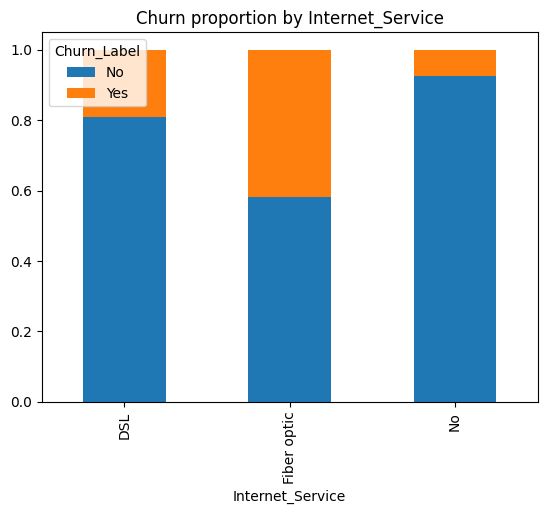

Churn_Label,No,Yes
Online_Security,,
No,58.233276,41.766724
No internet service,92.595020,7.404980
Yes,85.388806,14.611194


Column Online_Security has strong relationship with Churn label.


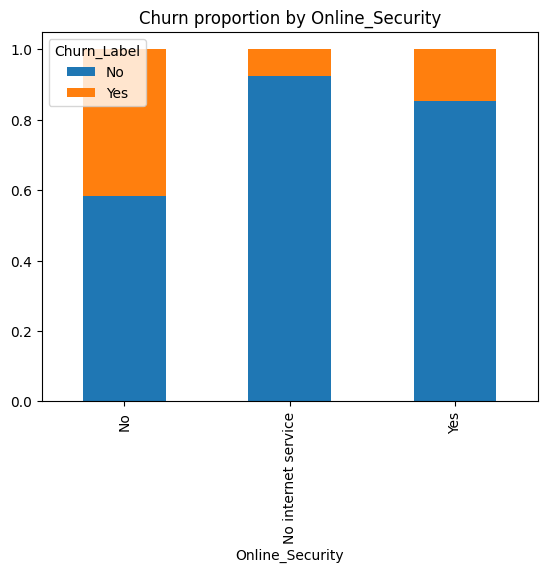

Churn_Label,No,Yes
Online_Backup,,
No,60.071244,39.928756
No internet service,92.595020,7.404980
Yes,78.468506,21.531494


Column Online_Backup has strong relationship with Churn label.


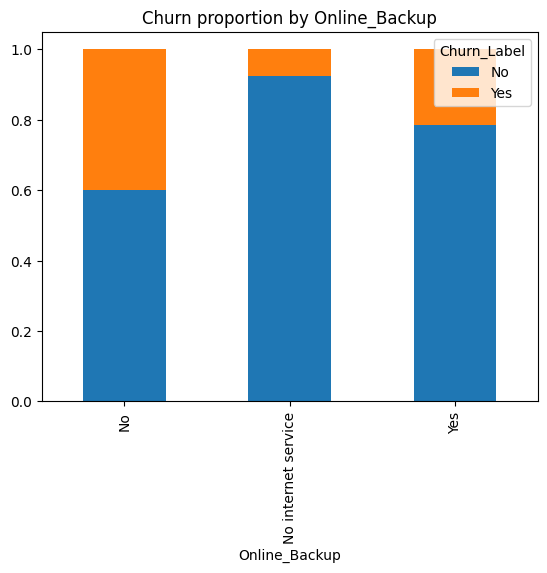

Churn_Label,No,Yes
Device_Protection,,
No,60.872375,39.127625
No internet service,92.595020,7.404980
Yes,77.497936,22.502064


Column Device_Protection has strong relationship with Churn label.


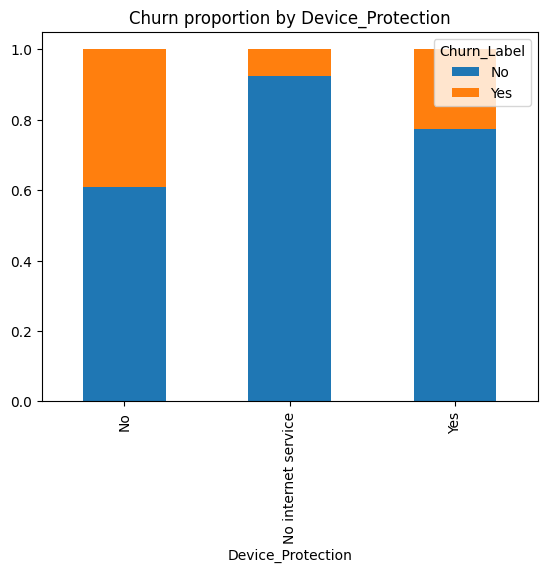

Churn_Label,No,Yes
Tech_Support,,
No,58.364526,41.635474
No internet service,92.595020,7.404980
Yes,84.833659,15.166341


Column Tech_Support has strong relationship with Churn label.


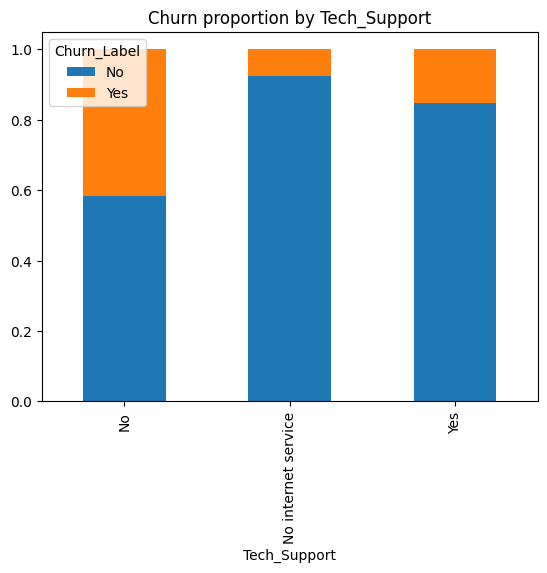

Churn_Label,No,Yes
Streaming_TV,,
No,66.476868,33.523132
No internet service,92.595020,7.404980
Yes,69.929812,30.070188


Column Streaming_TV has strong relationship with Churn label.


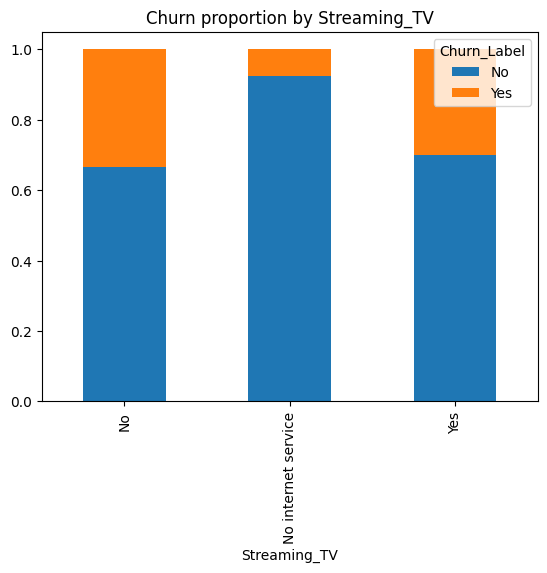

Churn_Label,No,Yes
Streaming_Movies,,
No,66.319569,33.680431
No internet service,92.595020,7.404980
Yes,70.058565,29.941435


Column Streaming_Movies has strong relationship with Churn label.


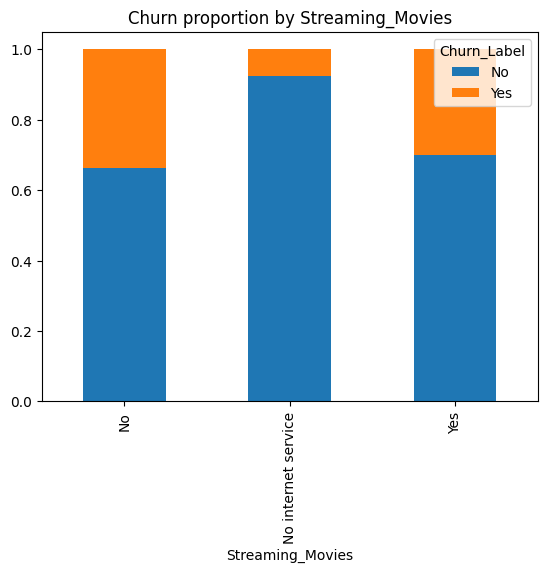

Churn_Label,No,Yes
Contract,,
Month-to-month,57.290323,42.709677
One year,88.730482,11.269518
Two year,97.168142,2.831858


Column Contract has strong relationship with Churn label.


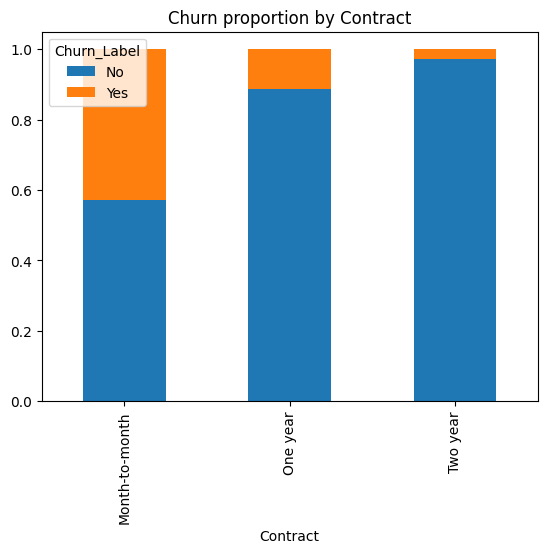

Churn_Label,No,Yes
Paperless_Billing,,
No,83.669916,16.330084
Yes,66.434908,33.565092


Column Paperless_Billing has strong relationship with Churn label.


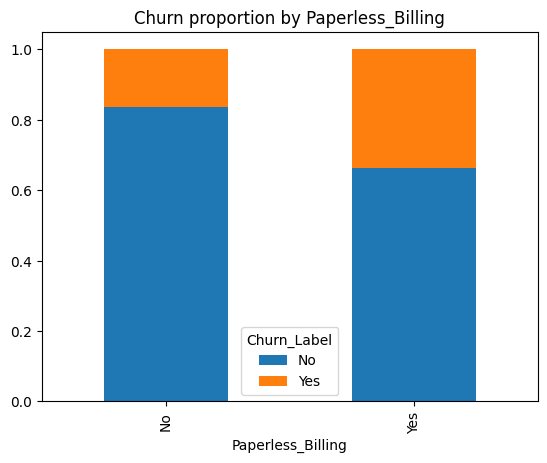

Churn_Label,No,Yes
Payment_Method,,
Bank transfer (automatic),83.290155,16.709845
Credit card (automatic),84.756899,15.243101
Electronic check,54.714588,45.285412
Mailed check,80.893300,19.106700


Column Payment_Method has strong relationship with Churn label.


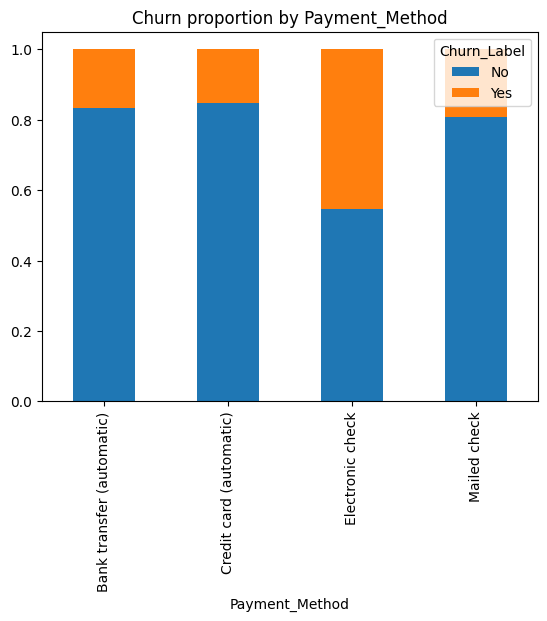

In [22]:
for col in telco.select_dtypes(include='object').columns[:-1]:
  cat_vs_churn(col)

In [23]:
def num_vs_churn(column):
    telco_num = telco.select_dtypes(exclude='object').drop('Churn_Value', axis=1).fillna(method='ffill')
    data1 = telco_num[telco['Churn_Label']==0][column]
    data2 = telco_num[telco['Churn_Label']==1][column]

    stat, p = stats.ttest_ind(a=data1, b=data2, equal_var=True)
    if(p<0.05):
        print(f'Column {column} has strong relationship with Churn.')
    else:
        print(f'Column {column} has weak relationship with Churn.')
    telco_ = telco.copy()
    telco_['Churn_Value'] = telco_['Churn_Value'].astype('category')
    plt.figure(figsize=(10,5))
    plt.title(f'{col} distribution Split by ChargeOff')
    sns.boxplot(data=telco_, y='Churn_Value', x=column, )
    plt.legend()
    plt.show()
    print('------------------------------------------------------------------------------')

Column Tenure_Months has weak relationship with Churn.


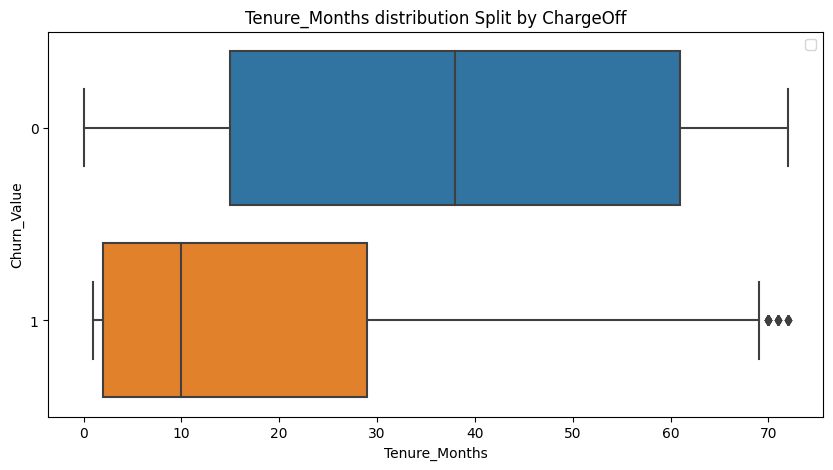

------------------------------------------------------------------------------
Column Monthly_Charges has weak relationship with Churn.


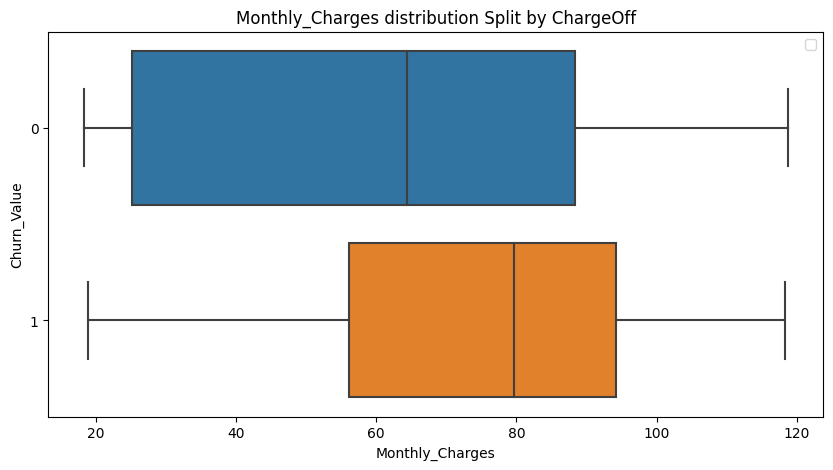

------------------------------------------------------------------------------
Column Total_Charges has weak relationship with Churn.


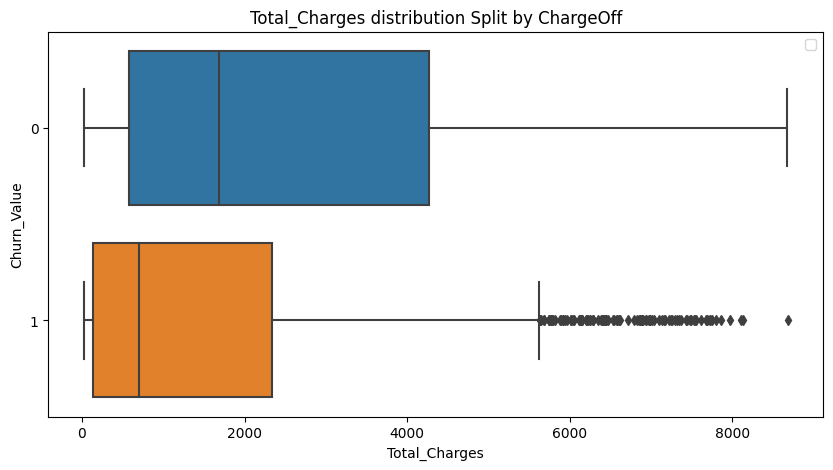

------------------------------------------------------------------------------
Column CLTV has weak relationship with Churn.


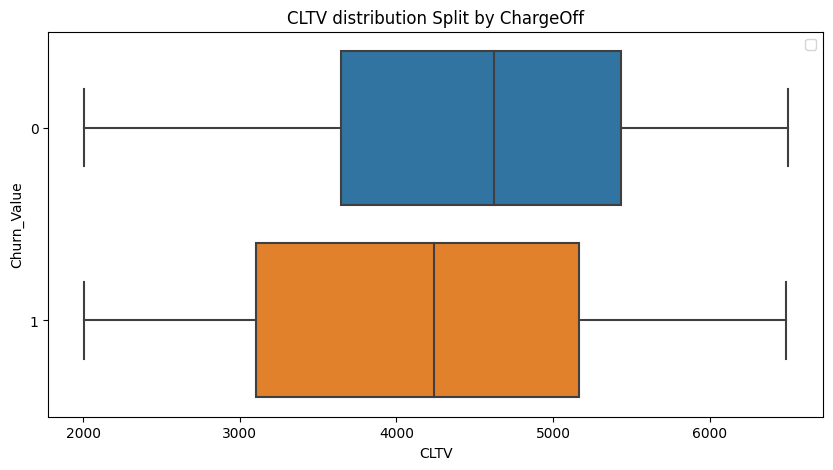

------------------------------------------------------------------------------


In [24]:
for col in telco.select_dtypes(exclude='object').drop('Churn_Value', axis=1).columns:
    num_vs_churn(col)

<Axes: >

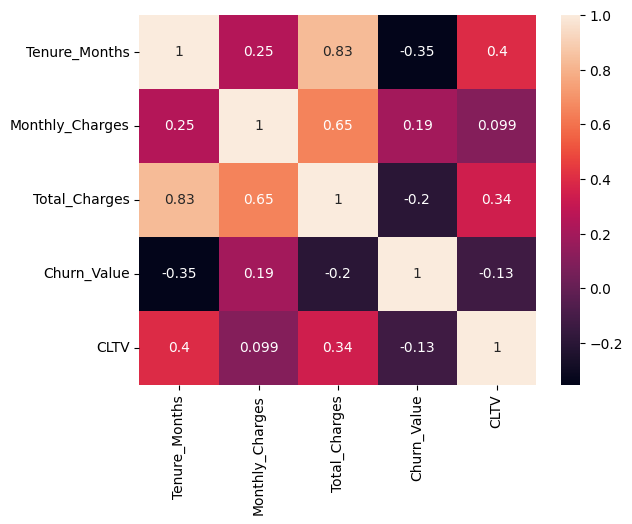

In [25]:
sns.heatmap(telco.select_dtypes(exclude='object').corr(), annot=True)

In [26]:
vif_data = pd.DataFrame()
telco_num = telco.select_dtypes(exclude='object').drop('Churn_Value', axis=1).fillna(method='ffill')
vif_data["feature"] = telco_num.columns
vif_data["VIF"] = [vif(telco_num.values, i)
                          for i in range(len(telco_num.columns))]
vif_data

,feature,VIF
0,Tenure_Months,12.420825
1,Monthly_Charges,9.544491
2,Total_Charges,12.321048
3,CLTV,9.252702


In [27]:
vif_data = pd.DataFrame()
telco_num = telco.select_dtypes(exclude='object').drop(['Tenure_Months', 'Monthly_Charges', 'Churn_Value'], axis=1).fillna(method='ffill')
vif_data["feature"] = telco_num.columns
vif_data["VIF"] = [vif(telco_num.values, i)
                          for i in range(len(telco_num.columns))]
vif_data

,feature,VIF
0,Total_Charges,2.268502
1,CLTV,2.268502


In [28]:
city_count = telco.groupby('City').agg({'City':'count'}).rename(columns={'City':'count'}).reset_index()
city_count.describe()

,count
count,1129.000000
mean,6.238264
std,12.254863
min,4.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,305.000000


In [29]:
city_count

,City,count
0,Acampo,4
1,Acton,4
2,Adelanto,5
3,Adin,4
4,Agoura Hills,5
...,...,...
1124,Yreka,4
1125,Yuba City,8
1126,Yucaipa,4
1127,Yucca Valley,5


In [30]:
telco

,City,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label,Churn_Value,CLTV
0,Los Angeles,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,3239
1,Los Angeles,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,2701
2,Los Angeles,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,5372
3,Los Angeles,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,5003
4,Los Angeles,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,5340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No,0,5306
7039,Adelanto,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0,2140
7040,Amboy,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0,5560
7041,Angelus Oaks,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,2793


In [31]:
telco = telco.merge(city_count, on='City')
telco['New_City'] = np.where(telco['count']<7, 'Other', telco['City'])

### __4. Machine Learning Modelling__
For the modelling stage, this churn prediction will focus on as much as possible in predicting which customers will churn. As we know, if this model predicts 'retain' for a customer that will actually 'churn', then we will lose the customer. And according to some opinions, the cost of customer acquisition is 7 times greater than the cost of retaining the customer.

So that in modeling this time we will focus on Recall Score. And we will try to use PR (Precision Recall) Curve to find the optimum threshold.

#### __4.1 Strategy__
In the modelling step, I will use Pipeline to help me building the model. First of all, I will divide the data into two category:
1. Categorical Variable
2. Quantitative Variable

Categorical variable is a data that take category or label values. In the other hands, quantitative variable take numerical values and represent some kind of measurement.

There are 18 columns that I listed as categorical variable. And since most of them only have 2 to 4 unique values, and each value has no order with each other, I will encode them using __One-Hot Encoding__.

The rest of the columns should be listed in the other category, and since each column has big different in value range with each other, so I will try to scale them using __Min-Max Scaler__ or __Standard Scaler__.

Since there are no missing values, then I don't need imputer in this process.

The first model that I will use is __Logistic Regression__. After that, if needed, I will try to use Deep Learning method to build the model.

In [32]:
telco2 = telco.drop(['City', 'count', 'Churn_Label', 'Tenure_Months', 'Monthly_Charges'], axis=1).copy()
X = telco2.drop(columns='Churn_Value')
y = telco2['Churn_Value']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=.2, stratify=y, random_state=2023)

In [33]:
X_train_val.shape

(5634, 19)

In [34]:
X_test.shape

(1409, 19)

#### __4.2 Initiating Machine Learning Pipeline__

##### __4.2.1 Logistic Regression__

In [35]:
one_hot_cols = X.select_dtypes(include='object').columns
numeric_cols = X.select_dtypes(exclude='object').columns
logit = LogisticRegression(random_state=2021)
smote = SMOTE(random_state=2023)

logit_pipe_num = Pipeline([
    ('imputer', SimpleImputer(strategy='median', missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1, random_state=1))
])

# for all object columns
logit_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first')),
])

# transforming all columns
logit_transformer = ColumnTransformer([
    ('pipe_num', logit_pipe_num, numeric_cols),
    ('pipe_cat', logit_pipe_cat, one_hot_cols)
])

# combine all pipeline
logit_pipe_combine = Pipeline([
    ('transformer', logit_transformer),
    ('rfe', RFE(logit)),
    ('resampling', smote),
    ('logit', logit)
])

In [36]:
numeric_cols, one_hot_cols

(Index(['Total_Charges', 'CLTV'], dtype='object'),
 Index(['Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service',
        'Multiple_Lines', 'Internet_Service', 'Online_Security',
        'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
        'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
        'New_City'],
       dtype='object'))

In [37]:
skf = StratifiedKFold(n_splits=5)

logit_score = cross_val_score(logit_pipe_combine, X_train_val, y_train_val, scoring='recall', cv=skf, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.3s finished


In [38]:
logit_score

array([0.75919732,        nan, 0.80602007, 0.82274247, 0.7826087 ])

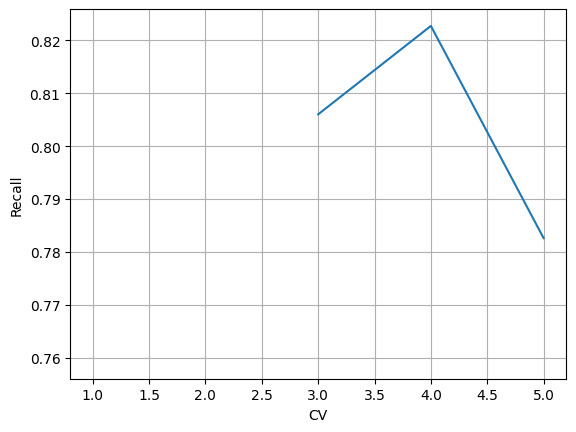

Logit Val Score: nan


In [39]:
plt.plot(range(1, len(logit_score)+1), logit_score)
plt.xlabel('CV')
plt.ylabel('Recall')
plt.grid()
plt.show()
print('Logit Val Score:', logit_score.mean())

In [40]:
logit_pipe_combine.fit(X_train_val, y_train_val)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=1,
                                                                       random_state=1))]),
                                                  Index(['Total_Charges', 'CLTV'], dtype='object')),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['Gender', 'Senior_...
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'New_City'],
      dtype='object'))])),
                ('rfe', RFE(estimator=LogisticRegression(random_state=2021))),
                ('resampling', SMOTE(random_state=2023)),
                ('logit', LogisticRegression(random_state=2021))])

In [41]:
recall_score(y_test,logit_pipe_combine.predict(X_test))

0.7994652406417112

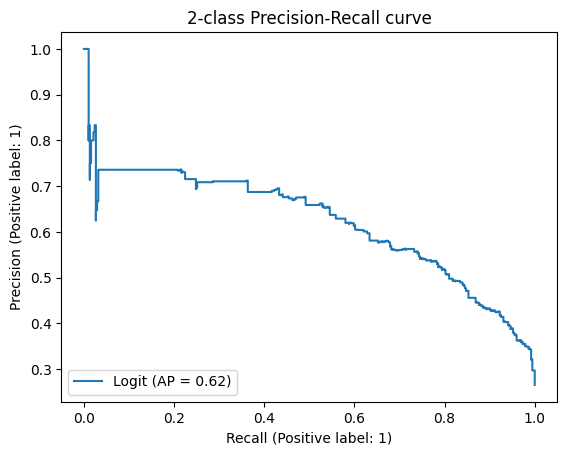

In [42]:
display_ = PrecisionRecallDisplay.from_estimator(
    logit_pipe_combine, X_test, y_test, name="Logit")
_ = display_.ax_.set_title("2-class Precision-Recall curve")

In [43]:
y_scores = logit_pipe_combine.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test.values, y_scores)
df_thres = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Threshold': thresholds})
df_thres

,Precision,Recall,Threshold
0,0.265436,1.000000,0.003998
1,0.265625,1.000000,0.004562
2,0.265814,1.000000,0.004879
3,0.266003,1.000000,0.004941
4,0.266192,1.000000,0.005512
...,...,...,...
529,0.800000,0.010695,0.916759
530,1.000000,0.010695,0.918996
531,1.000000,0.008021,0.919687
532,1.000000,0.005348,0.921488


In [44]:
df_thres[df_thres['Recall'].between(.85, .9)]

,Precision,Recall,Threshold
289,0.431877,0.898396,0.316581
290,0.431145,0.895722,0.316856
291,0.431701,0.895722,0.318669
292,0.430968,0.893048,0.318741
293,0.431525,0.893048,0.318775
294,0.432083,0.893048,0.320316
295,0.432642,0.893048,0.324183
296,0.433766,0.893048,0.324975
297,0.433594,0.890374,0.326849
298,0.434159,0.890374,0.328190


In [45]:
pred_31 = np.where(y_scores>0.317119, 1, 0)
recall_31 = recall_score(y_test,pred_31)
recall_31

0.8957219251336899

In [46]:
confusion_matrix(y_test, pred_31)

array([[594, 441],
       [ 39, 335]])

![picture](https://drive.google.com/uc?id=1nCO5ftdYM6Qxs765Kn2GAstgBM4KR1Q7)

In [47]:
335/(441+335)

0.43170103092783507